In [18]:
%matplotlib inline
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

In [2]:
cfg = local_import("./default.py")

In [3]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Shape of answer df (2028240, 21)
Loading word dictionary...
Warning! Dropping some words from word list, please verify!
Calculating normalized columns...


In [4]:
data = cfg.data

In [5]:
data.keys()

['meta', 'dict', 'features', 'answers']

In [6]:
qs = data["meta"];

In [7]:
qs.head()
print qs.shape

(673622, 46)


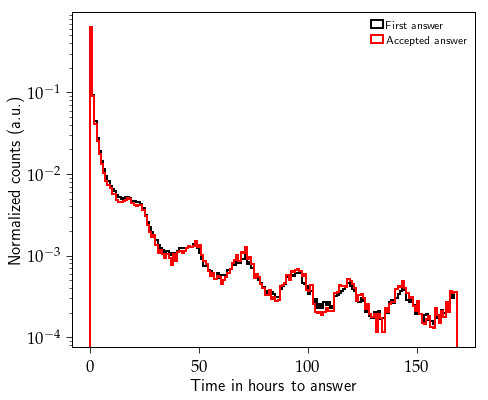

In [19]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Normalized counts (a.u.)")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", normed=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", normed=True);
plt.semilogy(nonposy="clip")
plt.legend(loc="upper right");

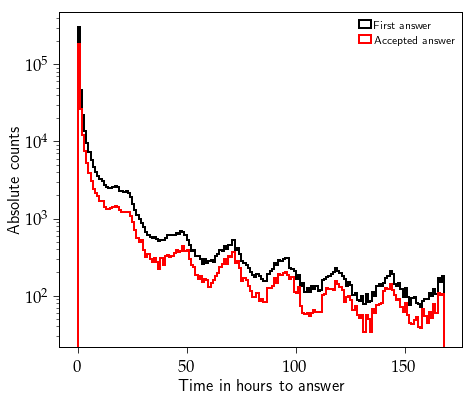

In [11]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Absolute counts")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer");
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer");
plt.semilogy(nonposy="clip")
plt.legend(loc="upper right");

[]

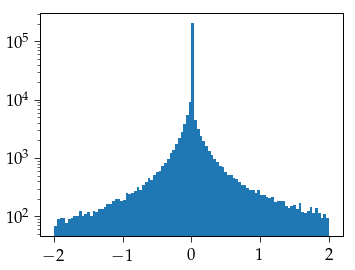

In [13]:
plt.hist(qs.dt_accanswer_hour - qs.dt_answer_hour, range=[-2, 2], bins=100);
plt.semilogy(nonposy="clip")

In [14]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

536044
307514


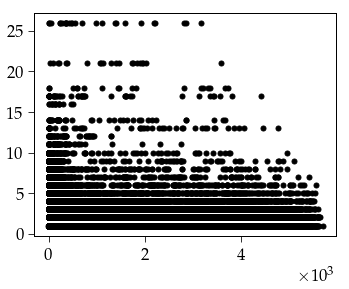

In [15]:
plt.plot(qs.dt_answer_hour, qs.AnswerCount, "k.")

In [26]:
qs.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordersum', u'prob_bern', u'prob_poiss', u'ratio', u'ParentId_first',
       u'CreationDate_first', u'Id_acc', u'CreationDate_acc', u'dt_answer',
       u'dt_accanswer'],
      dtype='object')

[ 1.  4.]


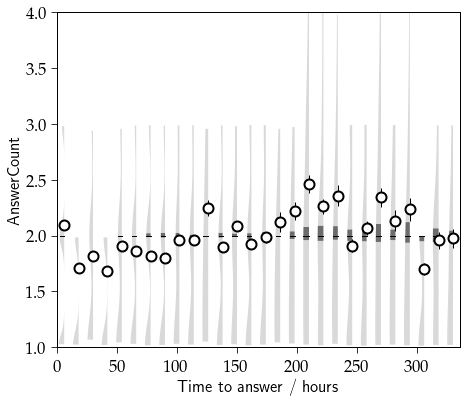

[ 0.  7.]


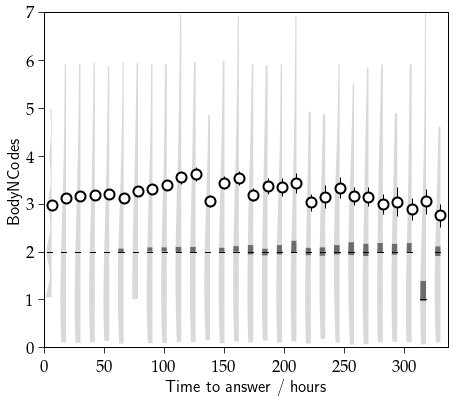

[ 0.  3.]


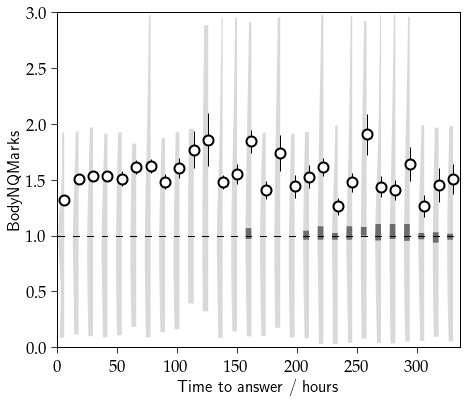

[  396.  3127.]


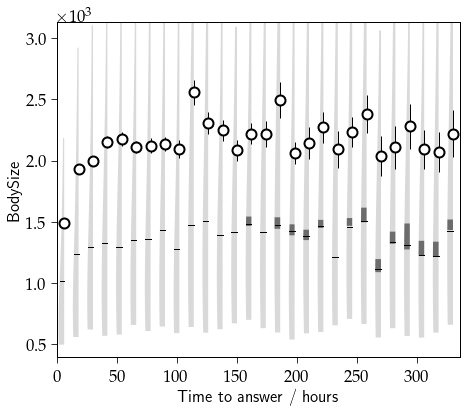

[ 31.  80.]


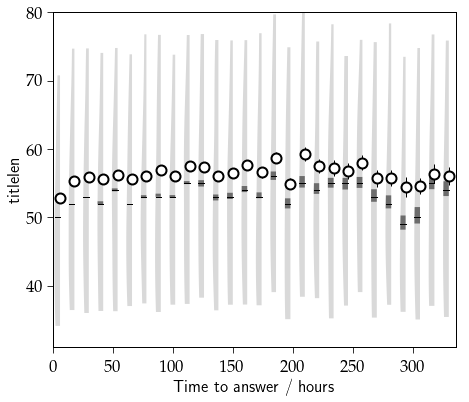

[ 14.  74.]


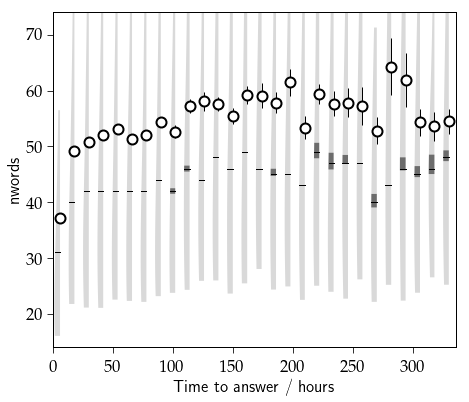

[  2974.  23345.]


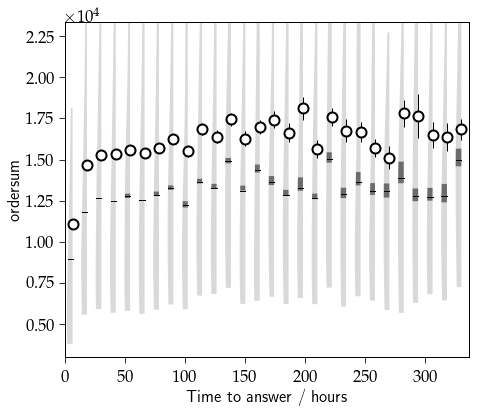

[ 0.26086957  0.88235294]


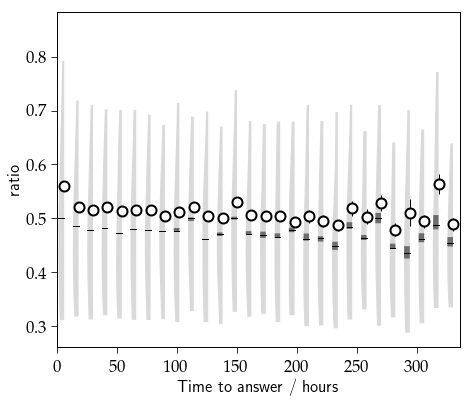

[ 0.  2.]


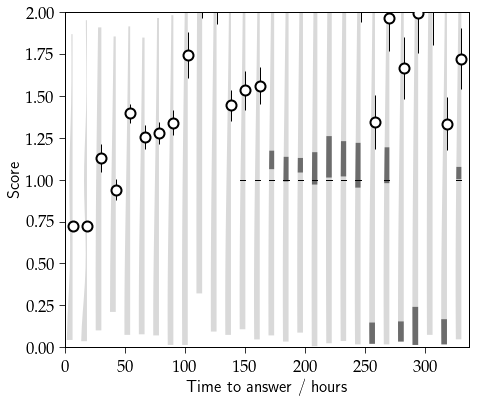

[  2.23909674e-54   3.09808260e-18]


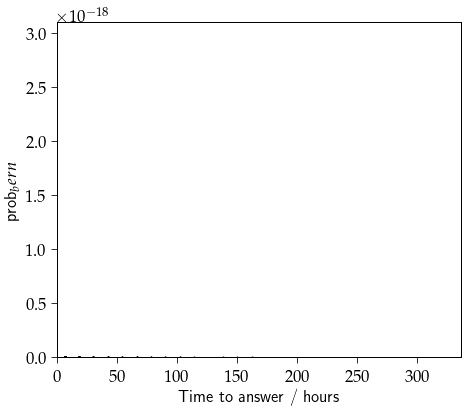

In [20]:
from scipy.stats.mstats import mquantiles

qs.columns
m = np.isfinite(qs.dt_accanswer_hour)

ndays = 14
# dthours = qs.dt_answer.dt.total_seconds() * 1. / 3600
cols = ["AnswerCount", "BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ratio", "Score", "prob_bern"]
# f, axarr = plt.subplots(2, 4, squeeze=False)
for i, col in enumerate(cols):
    quants = mquantiles(qs[m][col], prob=[0.1, 0.9])
    print quants
    plt.figure(i, figsize=(8, 6))
    plt.xlabel(r"Time to answer / hours")
    plt.ylabel(r"%s" % col)
#     plt.plot(dthours, qs[col], "k.")
    QuickSlicePlot(qs.dt_accanswer_hour[m], qs[m][col], qs.dt_accanswer_hour[m], zbins=1, yrange=quants, 
                   xRange=[0, ndays * 24], xbins=2 * ndays, draw="amvs",
                   axes=plt.gca())
    plt.xlim(0, ndays * 24)
    plt.show()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

In [184]:
# training and testing samples
qs = shuffle(qs)
print len(qs)
# limiting to questions with accepted answer for training
qsgood = qs[~qs.dt_accanswer.isnull()]
# for training, consider only first weeks for answer time (due to reweighting)
qsgood = qsgood[qsgood.dt_accanswer_hour <= 14 * 24]
qsgood = qsgood[qsgood.dt_accanswer_hour > 0]
print len(qsgood)
train = 200000
qstrain = qsgood.iloc[:train]
qstest = qsgood.iloc[train:]
print len(qstrain)
print len(qstest)

label = "dt_accanswer_hour"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print len(qsnone)

673622
297772
200000
97772
137566


In [104]:
np.digitize?

In [163]:
# we probably want to reweight events according to the steeply falling time distribution...
#max(qstrain.dt_accanswer_hour)
# counts, edges = np.histogram(qstrain.dt_accanswer_hour, mquantiles(qstrain.dt_accanswer_hour, prob=np.linspace(0., 1., 100)))
counts, edges = np.histogram(qstrain.dt_accanswer_hour, bins=300)
counts = counts * 1. / np.sum(counts)
counts;
print edges[:10];
weights = 1. / counts[np.minimum(np.digitize(qstrain.dt_accanswer_hour.values, edges) - 1, len(counts) - 1)]
print qstrain.dt_accanswer_hour.iloc[:10]
print weights[:10]
qstrain["weights"] = weights

[  0.           2.23989384   4.47978768   6.71968152   8.95957536
  11.1994692   13.43936304  15.67925688  17.91915072  20.15904456]
554052    3.567648
140446    0.050472
589606    1.547712
667243    0.042672
501769    0.141240
70175     0.110136
66489     0.632400
528092    0.086184
312564    2.313672
390284    0.417360
Name: dt_accanswer_hour, dtype: float64
[ 16.31534295   1.41334766   1.41334766   1.41334766   1.41334766
   1.41334766   1.41334766   1.41334766  16.31534295   1.41334766]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [140]:
qstrain.columns


Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordersum', u'prob_bern', u'prob_poiss', u'ratio', u'ParentId_first',
       u'CreationDate_first', u'Id_acc', u'CreationDate_acc', u'dt_answer',
       u'dt_accanswer', u'dt_answer_hour', u'dt_accanswer_hour',
       u'BodyNCodes_norm', u'BodyNQMarks_norm', u'BodySize_norm',
       u'titlelen_norm', u'nwords_norm', u'ordersum_norm', u'ratio_norm',
       u'weights'],
      dtype='object')

In [62]:
import dill
# dill.dump(estimator, open('estimator.dill', 'w'))
# estimator = dill.load(open('estimator.dill', 'r'))

## Fitting random forest to the space of simple features derived from the text

In [68]:
[col for col in qstrain.columns if "_norm" in col]

['BodyNCodes_norm',
 'BodyNQMarks_norm',
 'BodySize_norm',
 'titlelen_norm',
 'nwords_norm',
 'ordersum_norm',
 'ratio_norm']

In [201]:
pipe_feat_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer([col for col in qstrain.columns if "_norm" in col])),
         ("poly", PolynomialFeatures(degree=3)),
#          ("ridge", Ridge(alpha=a, normalize=True))
         ("ranforest", RandomForestRegressor(n_estimators=15))
    ])

pipe_feat = pipe_feat_fct(2)

In [ ]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

for alpha in np.linspace(0.1, 10, 20):
    pipe = pipe_feat_fct(alpha)
    pipe.fit(qstrain, np.log(qstrain[label]))
    print alpha, compute_error(pipe, qstrain, np.log(qstrain[label]))

In [202]:
# pipe_feat.fit(qstrain, qstrain[label], **{"ridge__sample_weight": qstrain.weights})
pipe_feat.fit(qstrain, np.log(qstrain[label]))
pred = pipe_feat.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
# print pipe_feat.score(qstest, qstest[label])
print pipe_feat.score(qstest, np.log(qstest[label]))

[[ 0.2666181   0.28596059]
 [-1.66883384  0.76231124]
 [-1.79416259 -0.94672932]
 ..., 
 [-0.17717496 -0.69239546]
 [ 0.12844986 -2.72796723]
 [ 2.20775256  2.19066176]]
0.406137849938


In [150]:
dill.dump(pipe_feat, open("pipe_feat.dill", "w"))

In [ ]:
pipe_feat = dill.load(open('pipe_feat.dill', 'r'))

## Investigating difference (residuals) in test sample vs. various dimensions

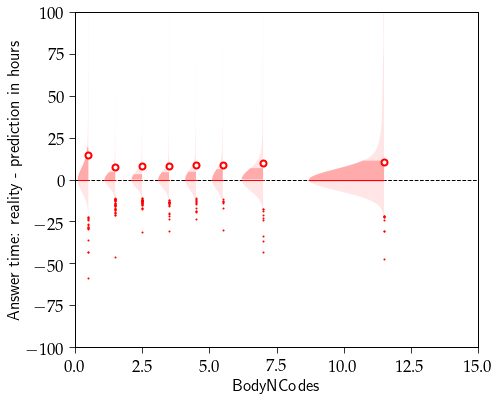

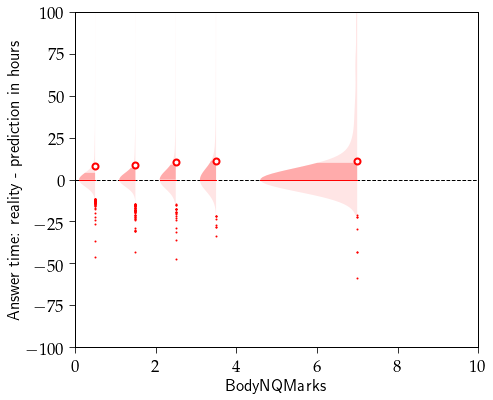

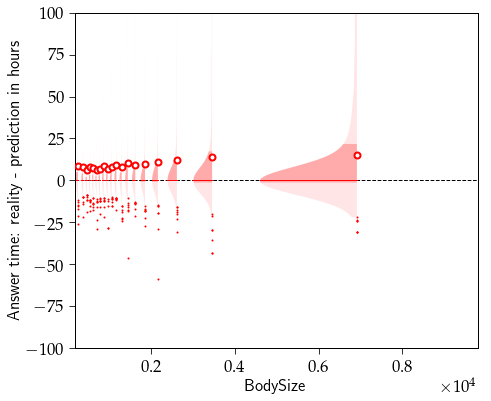

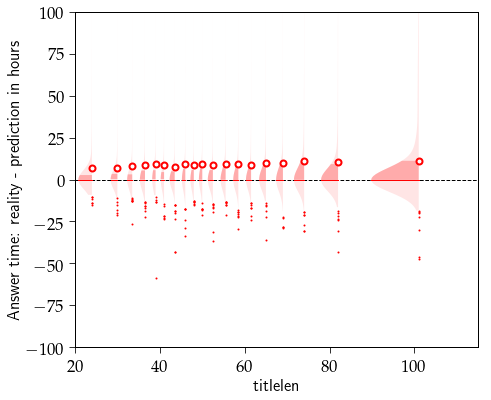

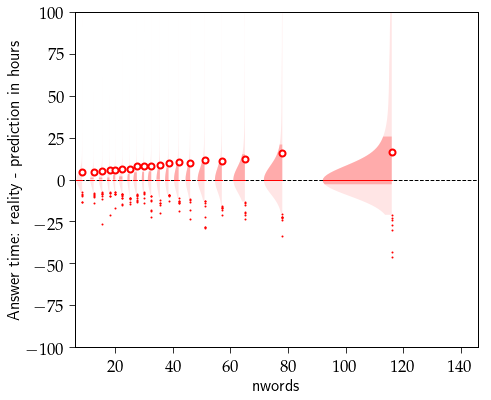

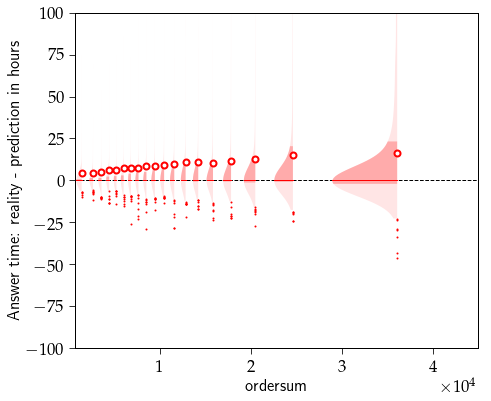

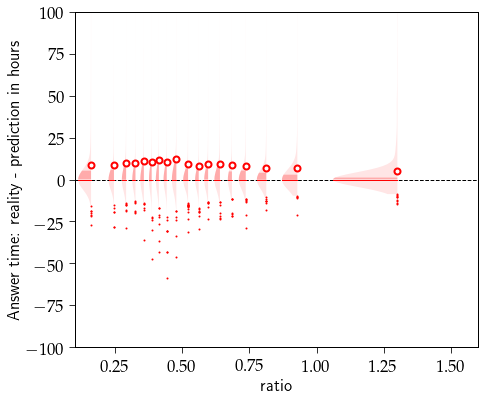

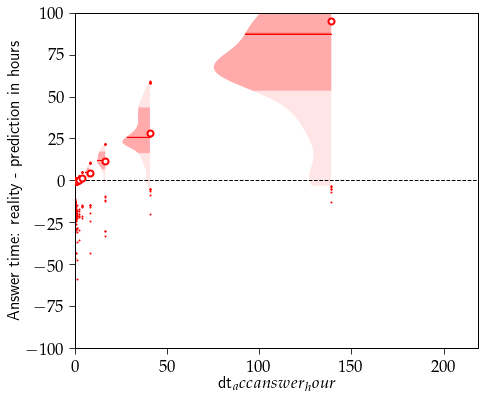

In [203]:
cols = [col.replace("_norm", "") for col in qstrain.columns if "_norm" in col] + ["dt_accanswer_hour"]
diff = qstest[label] - np.e ** pred

for i, col in enumerate(cols):
    yquants = mquantiles(diff, prob=[0.05, 0.95])
    xquants = mquantiles(qstest[col], prob=np.linspace(0.01, 0.99, 20))
    plt.figure(i, figsize=(8, 6))
    plt.xlabel("%s" % col)
    plt.ylabel(r"Answer time: reality - prediction in hours")
    QuickSlicePlot(qstest[col], diff, qstest.dt_accanswer_hour, zbins=1, yrange=yquants, 
                   xbins=xquants, draw="amv", color="red", ms=6,
                   axes=plt.gca())
    plt.axhline(0, lw=1, ls="--", color="k")
    plt.ylim(-100, 100)
    plt.xlim(min(xquants), max(xquants))
    plt.show()